# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
# Install imageio for imread as imread from scipy.misc is deprecated

!pip install imageio
#!pip install opencv-python
!pip install scikit-image

In [2]:
import numpy as np
import os

# following in deprecated:
# from scipy.misc import imread, imresize
from imageio import imread
from skimage.transform import resize
from PIL import Image
#import cv2

import datetime
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#ignore warnings
import warnings
warnings.filterwarnings("ignore")

We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf

# set_random_seed is deprecated.
# tf.set_random_seed(30)
tf.random.set_seed(30)

2021-10-22 21:51:23.707265: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /snap/alacritty/46/usr/lib/x86_64-linux-gnu:/snap/alacritty/46/lib/x86_64-linux-gnu:/snap/alacritty/46/usr/lib/x86_64-linux-gnu/dri
2021-10-22 21:51:23.707290: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
# train_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/train.csv').readlines())
# val_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/val.csv').readlines())

train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())

#hyperparameters
batch_size = 64 #experiment with the batch size
image_height = 160
image_width = 160

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [6]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.round(np.linspace(0, 29, 30)).astype(int) #list of image numbers for video.
    while True:
        t = np.random.permutation(folder_list)
        if len(t) % batch_size == 0: # if divisible by batch_size
            num_batches = int(len(t)/batch_size)
            last_batch_size = 0
        else:  #if not divisible by batch_size
            num_batches = len(t) // batch_size
            last_batch_size = len(t) % batch_size #surplus in the last batch
        
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),image_height,image_width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized_image = resize(image,(image_height,image_width))
                    
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if len(t) % batch_size != 0: # if not divisible by batch_size
            batch_data = np.zeros((last_batch_size,len(img_idx),image_height,image_width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((last_batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(last_batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*last_batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*last_batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    resized_image = resize(image,(image_height,image_width))

                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [7]:
curr_dt_time = datetime.datetime.now()
# train_path = '/notebooks/storage/Final_data/Collated_training/train'
# val_path = '/notebooks/storage/Final_data/Collated_training/val'
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


# Model 1 - Conv3D
## Batch size = 64, No. of Epochs  = 20

Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [8]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

In [9]:
# Conv3D model
model = Sequential()
model.add(Conv3D(16, (3,3,3), # filters, kernel size
                 padding = 'same', 
                 input_shape = (30,160,160,3))) #frames to sample, height, weight, channels
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(5,activation='softmax'))

2021-10-22 21:51:24.662424: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-22 21:51:24.663362: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /snap/alacritty/46/usr/lib/x86_64-linux-gnu:/snap/alacritty/46/lib/x86_64-linux-gnu:/snap/alacritty/46/usr/lib/x86_64-linux-gnu/dri
2021-10-22 21:51:24.663476: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /snap/alacritty/46/usr/lib/x86_64-linux-gnu:/snap/alacritty/46/lib/x86_64-linux-gnu:/snap/alacritty/46/usr/lib/x86_64-linux-gnu/dri
2021-10-22 21:51:24.6635

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [10]:
def compile_and_summarize(learning_rate = 0.01): 
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])
    print (model.summary())

compile_and_summarize()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 80, 80, 32)    4128      
_________________________________________________________________
activation_1 (Activation)    (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 80, 80, 32)    1

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [11]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [12]:
def model_checkpoints(model_prefix = 'model_init'):
    print('Initializing model checkpoints')
    model_name = model_prefix + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

    #reduce learning rate when val_loss has stopped improving.
    #monitor -> metric to monitor
    #verbose -> prints message to stdout
    #patience -> number of epochs with no imporvement after which learning rate is reduced
    #factor -> factor by which learning rate is reduced.
    LR = ReduceLROnPlateau(monitor='val_loss', factor= 0.2, verbose=1,patience=5)
    callbacks_list = [checkpoint, LR]
    return callbacks_list

callbacks_list = model_checkpoints()

Initializing model checkpoints


The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [13]:
def calc_steps_per_epoch(btch_size=64):
    print('Calculating steps per epoch and validation steps')
    if (num_train_sequences%btch_size) == 0:
        steps_per_epoch = int(num_train_sequences/btch_size)
    else:
        steps_per_epoch = (num_train_sequences//btch_size) + 1
    return steps_per_epoch

def calc_validation_steps(btch_size=64):
    if (num_val_sequences%btch_size) == 0:
        validation_steps = int(num_val_sequences/btch_size)
    else:
        validation_steps = (num_val_sequences//btch_size) + 1
    return validation_steps

steps_per_epoch = calc_steps_per_epoch(batch_size)
validation_steps = calc_validation_steps(batch_size)

Calculating steps per epoch and validation steps


Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

### <font color='red'> Uncomment below two cells to train and see the graph</font>

In [14]:
# history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
#                     callbacks=callbacks_list, validation_data=val_generator, 
#                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [15]:
def train_val_loss_plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

# train_val_loss_plot(history)

<font color='blue'>
    The above graph shows this model to be overfitted as the training loss is low while the validation loss is high. Accuracy is also not as high as expected. We can try with a more complex model to increase the training accuracy and change the dropout to reduce overfitting.
    </font>

# Model 2

In [16]:
# Conv3D model2
model = Sequential()
model.add(Conv3D(16, (3,3,3), # filters, kernel size
                 padding = 'same', 
                 input_shape = (30,160,160,3))) #frames to sample, height, weight, channels
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, (2,2,2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2,2,2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(256, (2,2,2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(5,activation='softmax'))

In [17]:
batch_size=32

compile_and_summarize()

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

callbacks_list = model_checkpoints('model_init2')

steps_per_epoch = calc_steps_per_epoch(batch_size)
validation_steps = calc_validation_steps(batch_size)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation_3 (Activation)    (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 15, 80, 80, 32)    4128      
_________________________________________________________________
activation_4 (Activation)    (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 15, 80, 80, 32)   

### <font color='red'> Uncomment below two cells to train and see the graph</font>

In [18]:
# history2 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
#                     callbacks=callbacks_list, validation_data=val_generator, 
#                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [19]:
# train_val_loss_plot(history2)

<font color='blue'>
    This model also overfits. There is some improvement in the training accuracy.
    </font>

# Model 3
## Learning rate = 0.0001

In [20]:
# Conv3D model3
model = Sequential()
model.add(Conv3D(16, (3,3,3), # filters, kernel size
                 padding = 'same', 
                 input_shape = (30,160,160,3))) #frames to sample, height, weight, channels
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, (2,2,2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2,2,2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(128, (2,2,2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(5,activation='softmax'))

In [21]:
batch_size=32

compile_and_summarize(0.0001)

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

callbacks_list = model_checkpoints('model_init3')

steps_per_epoch = calc_steps_per_epoch(batch_size)
validation_steps = calc_validation_steps(batch_size)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_7 (Conv3D)            (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation_7 (Activation)    (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 15, 80, 80, 32)    4128      
_________________________________________________________________
activation_8 (Activation)    (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 15, 80, 80, 32)   

### <font color='red'> Uncomment below two cells to train and see the graph</font>

In [22]:
# history3 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
#                     callbacks=callbacks_list, validation_data=val_generator, 
#                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [23]:
# train_val_loss_plot(history3)

<font color ='blue'> The model is still performing badly on the validation set. The training accuracy is also not high.</font>

# Model 4

In [24]:
# Conv3D model4
model = Sequential()
model.add(Conv3D(16, (3,3,3), # filters, kernel size
                 padding = 'same', 
                 input_shape = (30,160,160,3))) #frames to sample, height, weight, channels
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, (2,2,2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2,2,2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(128, (2,2,2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv3D(256, (2,2,2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.6))

model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.6))

model.add(Dense(5,activation='softmax'))

In [25]:
batch_size=32
num_epochs=30

compile_and_summarize(0.0002)

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

callbacks_list = model_checkpoints('model_init4')

steps_per_epoch = calc_steps_per_epoch(batch_size)
validation_steps = calc_validation_steps(batch_size)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_11 (Conv3D)           (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation_11 (Activation)   (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_11 (MaxPooling (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_12 (Conv3D)           (None, 15, 80, 80, 32)    4128      
_________________________________________________________________
activation_12 (Activation)   (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 15, 80, 80, 32)   

### <font color='red'> Uncomment below two cells to train and see the graph</font>

In [26]:
# history4 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
#                     callbacks=callbacks_list, validation_data=val_generator, 
#                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [27]:
# train_val_loss_plot(history4)

<font color='blue'> The model still overfits, but the accuracy has imporved a little - 71% for train and 58% for validation.</font>

# Model 5
### CNN + GRU

In [28]:
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.recurrent import GRU

In [29]:
#CNN + GRU model
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=(30,160,160,3)))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))


model.add(GRU(128))
model.add(Dropout(0.5))

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))

In [30]:
batch_size=32
num_epochs=20

compile_and_summarize(0.0002)

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

callbacks_list = model_checkpoints('model_init5')

steps_per_epoch = calc_steps_per_epoch(batch_size)
validation_steps = calc_validation_steps(batch_size)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 30, 160, 160, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 160, 160, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 80, 80, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 80, 80, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 80, 80, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 40, 40, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 40, 40, 64)   

In [31]:
# history5 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
#                     callbacks=callbacks_list, validation_data=val_generator, 
#                     validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [32]:
# train_val_loss_plot(history5)

<font color='blue'> CNN with GRU(RNN) also overfits.</font>

# Model 6

### CNN + GRU : Adding more dropout

In [33]:
#CNN + GRU model
model = Sequential()

model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=(30,image_height,image_width,3)))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.5))

model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.5))

model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(Dropout(0.5))

model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))

model.add(TimeDistributed(MaxPooling2D((2, 2))))

model.add(TimeDistributed(Flatten()))


model.add(GRU(128))
model.add(Dropout(0.5))

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))

In [34]:
batch_size=20
num_epochs=40

compile_and_summarize(0.0002)

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

callbacks_list = model_checkpoints('model_init6')

steps_per_epoch = calc_steps_per_epoch(batch_size)
validation_steps = calc_validation_steps(batch_size)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_16 (TimeDis (None, 30, 160, 160, 16)  448       
_________________________________________________________________
time_distributed_17 (TimeDis (None, 30, 160, 160, 16)  64        
_________________________________________________________________
time_distributed_18 (TimeDis (None, 30, 80, 80, 16)    0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 30, 80, 80, 16)    0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 30, 80, 80, 32)    4640      
_________________________________________________________________
time_distributed_20 (TimeDis (None, 30, 80, 80, 32)    128       
_________________________________________________________________
time_distributed_21 (TimeDis (None, 30, 40, 40, 32)   

In [35]:
history6 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/train ; batch size = 20


2021-10-22 21:51:29.153957: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40
34/34 [==============================] - 254s 7s/step - loss: 1.9697 - categorical_accuracy: 0.2247 - val_loss: 1.6912 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model_init6_2021-10-2221_51_24.592945/model-00001-1.96969-0.22474-1.69121-0.21000.h5
Epoch 2/40
34/34 [==============================] - 260s 8s/step - loss: 1.8106 - categorical_accuracy: 0.2685 - val_loss: 1.8913 - val_categorical_accuracy: 0.1900

Epoch 00002: saving model to model_init6_2021-10-2221_51_24.592945/model-00002-1.81062-0.26848-1.89130-0.19000.h5
Epoch 3/40
34/34 [==============================] - 264s 8s/step - loss: 1.6470 - categorical_accuracy: 0.3303 - val_loss: 1.8761 - val_categorical_accuracy: 0.2500

Epoch 00003: saving model to model_init6_2021-10-2221_51_24.592945/model-00003-1.64699-0.33032-1.87609-0.25000.h5
Epoch 4/40
34/34 [==============================] - 259s 8s/step - loss: 1.5958 - categorical_accuracy: 0.3243 - val_loss: 2.0993 - val_categorical_accuracy: 0.

34/34 [==============================] - 274s 8s/step - loss: 1.3212 - categorical_accuracy: 0.4103 - val_loss: 2.1746 - val_categorical_accuracy: 0.2000

Epoch 00028: saving model to model_init6_2021-10-2221_51_24.592945/model-00028-1.32116-0.41026-2.17457-0.20000.h5
Epoch 29/40
34/34 [==============================] - 275s 8s/step - loss: 1.2580 - categorical_accuracy: 0.4736 - val_loss: 2.1562 - val_categorical_accuracy: 0.1500

Epoch 00029: saving model to model_init6_2021-10-2221_51_24.592945/model-00029-1.25795-0.47360-2.15619-0.15000.h5
Epoch 30/40
34/34 [==============================] - 275s 8s/step - loss: 1.2383 - categorical_accuracy: 0.4676 - val_loss: 2.1409 - val_categorical_accuracy: 0.1900

Epoch 00030: saving model to model_init6_2021-10-2221_51_24.592945/model-00030-1.23829-0.46757-2.14085-0.19000.h5
Epoch 31/40
34/34 [==============================] - 274s 8s/step - loss: 1.2819 - categorical_accuracy: 0.4495 - val_loss: 2.0984 - val_categorical_accuracy: 0.2100

Ep

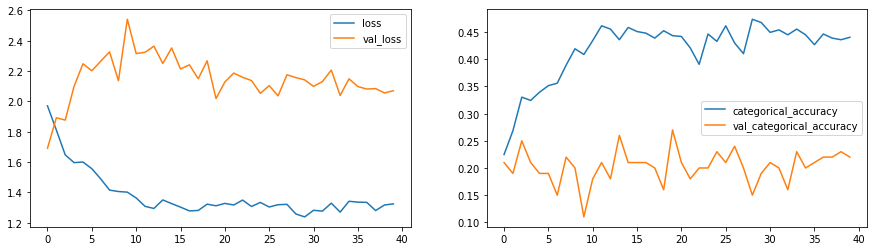

In [36]:
train_val_loss_plot(history6)